# Homework 1
### ASTROINFORMATICS FALL 2018
https://github.com/astromundus/astroinfo2018


## Problem 1

Using astroML figure 3.12 as a template, see

http://www.astroml.org/book_figures/chapter3/fig_cauchy_median_mean.html

add another panel, similar to the top panel, that will plot and compare 
results for standard deviation and $\sigma_G$. 


## Problem 2

Generate a sample of 10,000 data values drawn from N($\mu$=1.0, $\sigma$=0.2) and
draw a pretty histogram, with the bin size determined using the Freedman-Diaconis
rule. Show (Poissonian) uncertainty for each histogram value, and overplot the
true distribution. 

## Problem 3

Do the same for a Cauchy distribution with the same $\mu$ and $\gamma=0.2$. 

## Problem 4
Repeat the problem 2, but now add to the Gaussian sample (concatenate arrays) 
another sample of 10,000 data values drawn from a Cauchy distribution with
$\mu=2.0$ and $\gamma=0.5$. Do it twice: once with the bin size determined 
using the Freedman-Diaconis rule and once using the Scott's rule. Discuss the difference.  

<br>
# Solutions

### Some useful definitions and functions

In [1]:
import numpy as np
from matplotlib import pyplot as plt

This astroML function adjusts matplotlib settings for a uniform feel in the 
textbook. Note that with `usetex=True`, fonts are rendered with $\LaTeX$. This 
may result in an error if $\LaTeX$ is not installed on your system.  In that 
case, you can set usetex to `False`.

In [2]:
from astroML.plotting import setup_text_plots
from astroML.plotting import hist as fancyhist
from scipy import optimize
from scipy.stats import cauchy, norm
setup_text_plots(fontsize=12, usetex=True)
import scipy.stats
from scipy.stats import norm
from astroML import stats as astroMLstats

## Problem 1

In [3]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general


#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.

def robust_mean_mixture(x):
    """Compute the mean via a mixture of two Gaussians

    One Gaussian accounts for outliers, and one Gaussian accounts  for
    the true distribution.  This cannot be computed analytically, so
    it uses scipy's function optimization
    """
    if len(x) == 1:
        return x

    x = x.ravel()

    mu_bg = np.mean(x)
    sig_bg = 3 * np.std(x)

    likelihood = lambda v: -np.sum(np.log(norm.pdf(x, v[0], v[1])
                                          + norm.pdf(x, mu_bg, sig_bg)))

    v0 = np.array([0, 30])

    v_best = optimize.fmin(likelihood, v0, disp=False)

    return v_best[0]


def robust_mean_iterated(x, sigma_cut=3):
    """Compute the robust mean iteratively

    After computing the mean, points further than 3 sigma from the mean
    are removed and the result is repeated until convergence.
    """
    flag = np.ones(x.shape, dtype=bool)
    n_to_keep = x.size

    while True:
        xf = x[flag]
        mu = xf.mean()
        sig = xf.std()
        if len(xf) == 1:
            break

        x_sig = abs((x - mu) / sig)

        too_far = (x_sig > sigma_cut)
        flag[too_far] = False
        n_flag = flag.sum()

        if n_flag == n_to_keep:
            break
        else:
            n_to_keep = n_flag

    return mu

#------------------------------------------------------------

In [4]:
# Create the distribution and compute means and medians
np.random.seed(6)
mu = 0
gamma = 2

xi = cauchy(mu, gamma).rvs(100)
Nrange = np.arange(1, len(xi) + 1)

mean = [np.mean(xi[:N]) for N in Nrange]
median = [np.median(xi[:N]) for N in Nrange]
mean_mixture = [robust_mean_mixture(xi[:N]) for N in Nrange]
mean_iter = [robust_mean_iterated(xi[:N]) for N in Nrange]

stdev=[np.std(xi[:N]) for N in Nrange]
q75=[np.percentile(xi[:N], 75) for N in Nrange]
q25=[np.percentile(xi[:N], 25) for N in Nrange]
sigma_g=0.7413*np.subtract(q75,q25)
#------------------------------------------------------------

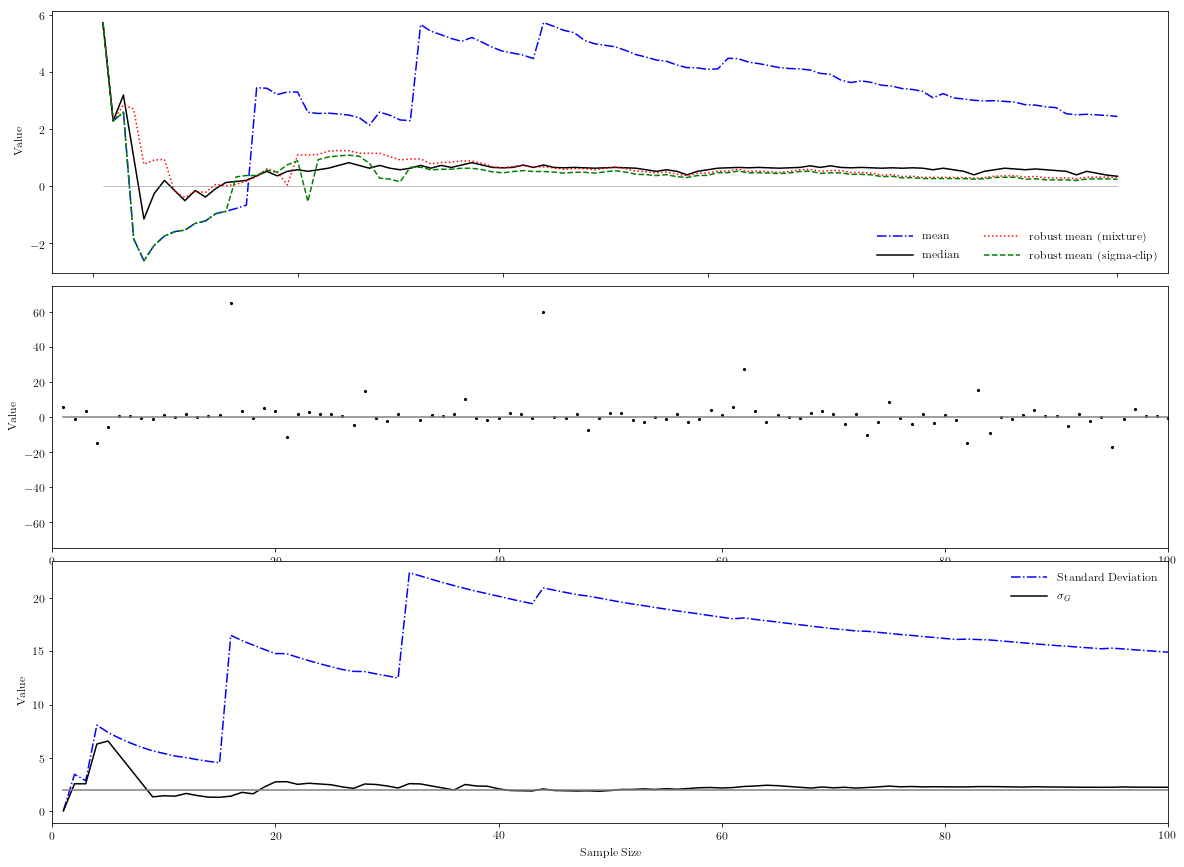

In [10]:
# Plot the results as a function of number of points
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.05)

# first plot the mean
ax = fig.add_subplot(411)
ax.plot(Nrange, mean, '-.b', label='mean')
ax.plot(Nrange, median, '-k', label='median')
ax.plot(Nrange, mean_mixture, ':r', label='robust mean (mixture)')
ax.plot(Nrange, mean_iter, '--g', label='robust mean (sigma-clip)')
ax.plot(Nrange, 0 * Nrange, '-', c='gray', lw=0.5)

#ax.set_xlim(0, 100)
#ax.set_ylim(-7, 7)
ax.legend(loc=4, ncol=2, frameon=False)
ax.set_ylabel('Value')
ax.xaxis.set_major_formatter(plt.NullFormatter())

# now plot the median
ax = fig.add_subplot(412)
ax.scatter(Nrange, xi, lw=0, s=10, c='k')
ax.plot(Nrange, 0 * Nrange, '-', c='gray')
ax.set_xlim(0, 100)
ax.set_ylim(-75, 75)
ax.set_xlabel('Sample Size')
ax.set_ylabel('Value')

# now plot the standard deviation and interquartile range 
ax = fig.add_subplot(413)
ax.plot(Nrange, stdev, '-.b', label='Standard Deviation')
ax.plot(Nrange, sigma_g, '-k', label='$\sigma_G$')
ax.plot(Nrange, 2+0 * Nrange, '-', c='gray')
ax.set_xlim(0, 100)
#ax.set_ylim(-30, 30)
ax.set_xlabel('Sample Size')
ax.set_ylabel('Value')
ax.legend(loc=1, ncol=1, frameon=False)

plt.show()

## Problem 2
Generate a sample of 10,000 data values drawn from N($\mu$=1.0, $\sigma$=0.2) and
draw a pretty histogram, with the bin size determined using the Freedman-Diaconis
rule. Show (Poissonian) uncertainty for each histogram value, and overplot the 
true distribution. 

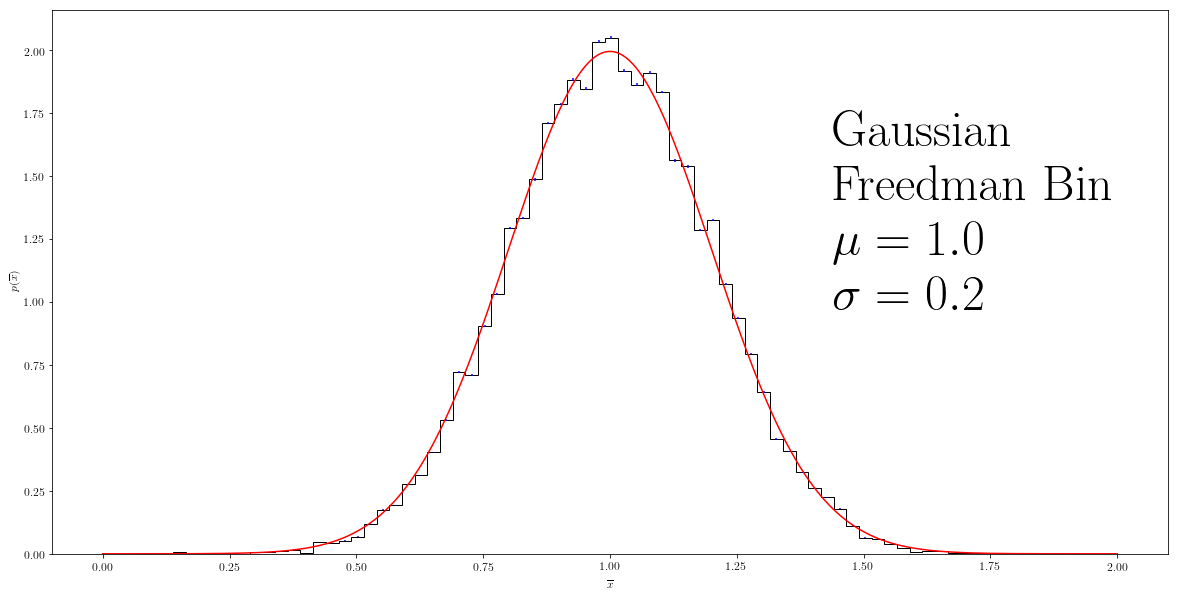

In [6]:
# points from gaussian distribution
mu=1.0
sigma=0.2
gauss = norm(mu, sigma).rvs(10000)

#plot histogram of gaussian in freedman bin
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
hist=fancyhist(gauss, bins="freedman", histtype="step",color="k",density=True)

#plot error bar
nk=hist[0]
binsize=hist[1][1:len(hist[1])]-hist[1][0:len(hist[1])-1]
uncer=np.sqrt(nk)/binsize/10000
plt.errorbar((hist[1][1:len(hist[1])]+hist[1][0:len(hist[1])-1])/2,nk,yerr=uncer,fmt=' ', ecolor='b',capthick=2)

#true gaussian distribution
x = np.linspace(0, 2, 1000)
gauss = norm(mu, sigma).pdf(x)  # this is a function of x: gauss(x)
plt.plot(x, gauss, ls='-', c='red', label='expected')

plt.xlabel('$\overline{x}$')
plt.ylabel(r'$p(\overline{x})$')
ax.annotate("Gaussian",(0.7,0.75),xycoords='axes fraction',size=50)
ax.annotate("Freedman Bin",(0.7,0.65),xycoords='axes fraction',size=50)
ax.annotate("$\mu=1.0$",(0.7,0.55),xycoords='axes fraction',size=50)
ax.annotate("$\sigma=0.2$",(0.7,0.45),xycoords='axes fraction',size=50)
plt.show()



## Problem 3

Do the same for a Cauchy distribution with the same $\mu$ and $\gamma=0.2$. 


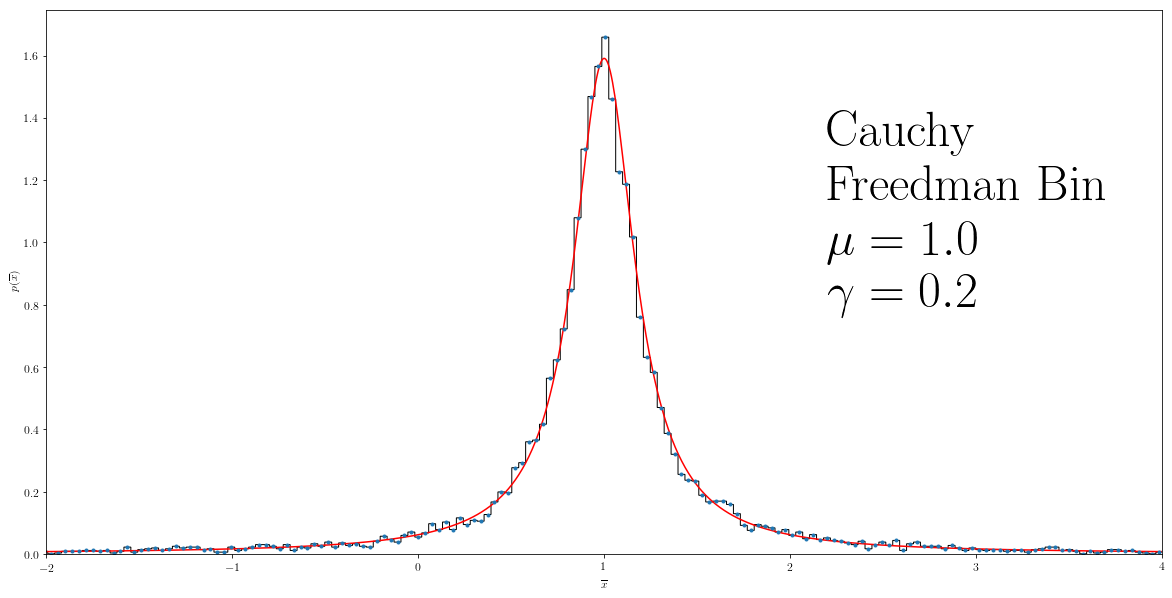

In [11]:
# points from cauchyy distribution
mu=1.0
gamma=0.2
cau=cauchy(mu,gamma).rvs(10000)

#plot histogram of cauchy in freedman bin
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
hist=fancyhist(cau, bins="freedman", histtype="step",color="k",density=True) # plot histogram of cauchy distribution
plt.xlim(-2,4)

#plot error bar
nk=hist[0]
binsize=hist[1][1:len(hist[1])]-hist[1][0:len(hist[1])-1]
uncer=np.sqrt(nk)/binsize/10000
plt.errorbar((hist[1][1:len(hist[1])]+hist[1][0:len(hist[1])-1])/2,nk,yerr=uncer,fmt='.', ecolor='r',capthick=2)

#plot true gaussian distribution
x = np.linspace(-2, 4, 1000)
cau = cauchy(mu, gamma).pdf(x)  # this is a function of x: gauss(x)
plt.plot(x, cau, ls='-', c='red', label='expected')

plt.xlabel('$\overline{x}$')
plt.ylabel(r'$p(\overline{x})$')
ax.annotate("Cauchy",(0.7,0.75),xycoords='axes fraction',size=50)
ax.annotate("Freedman Bin",(0.7,0.65),xycoords='axes fraction',size=50)
ax.annotate("$\mu=1.0$",(0.7,0.55),xycoords='axes fraction',size=50)
ax.annotate("$\gamma=0.2$",(0.7,0.45),xycoords='axes fraction',size=50)
plt.show()

## Problem 4

Repeat the problem 2, but now add to the Gaussian sample (concatenate arrays) 
another sample of 10,000 data values drawn from a Cauchy distribution with
$\mu=2.0$ and $\gamma=0.5$. Do it twice: once with the bin size determined 
using the Freedman-Diaconis rule and once using the Scott's rule. Discuss the difference.  

BIN SIZE FOR FREEDMAN: 0.07792177845840342
BIN SIZE FOR SCOTT: 18.08727876717603


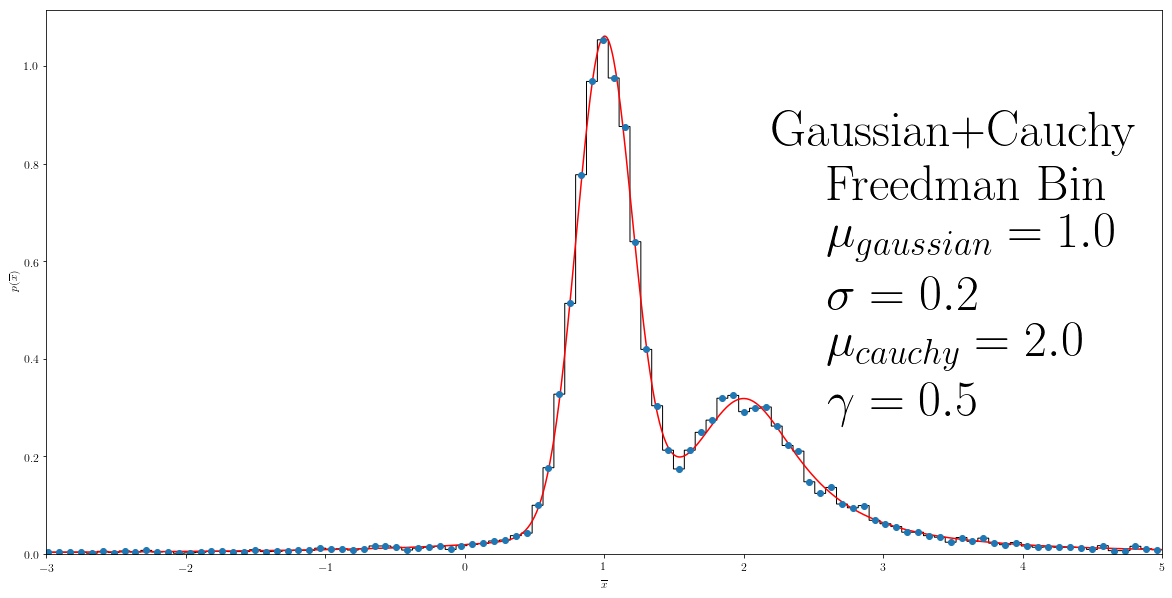

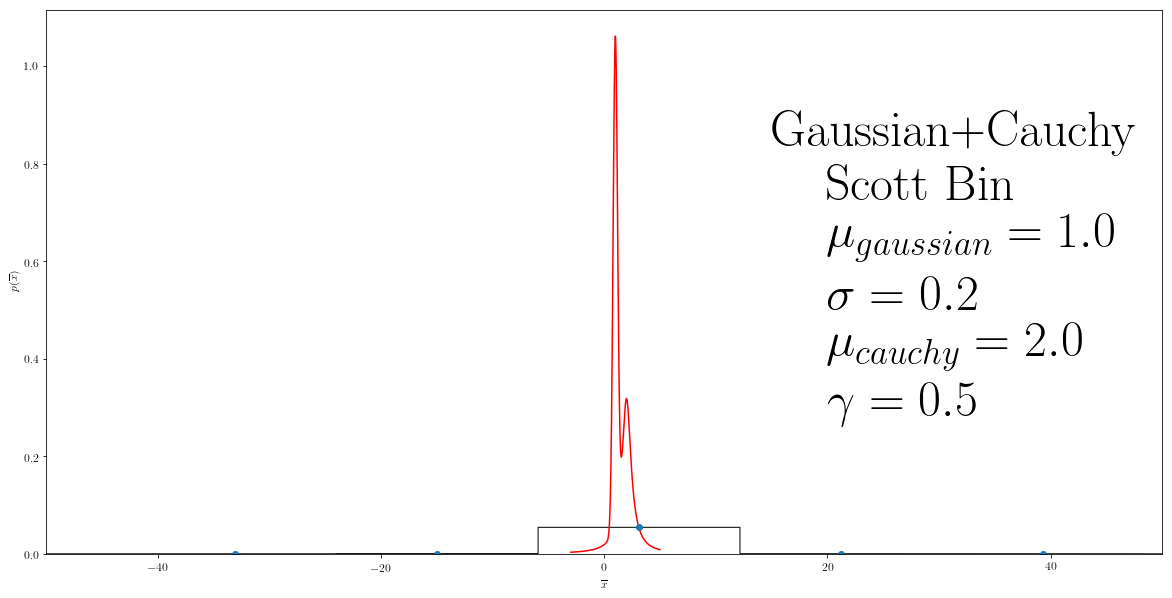

In [19]:
#concatenate gaussian and cauchy distribution
gauss = norm(1.0,0.2).rvs(10000)
cau=cauchy(2.0,0.5).rvs(10000)
cat=np.concatenate((gauss,cau))

#plot histogram of concatenated histogram using freedman
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
hist=fancyhist(cat, bins="freedman", histtype="step",color="k",density=True)
plt.xlim(-3,5)
nk=hist[0]
binsize=hist[1][1:len(hist[1])]-hist[1][0:len(hist[1])-1]
print("BIN SIZE FOR FREEDMAN:",binsize[0])

#plot error bars
uncer=np.sqrt(nk)/binsize/20000
plt.errorbar((hist[1][1:len(hist[1])]+hist[1][0:len(hist[1])-1])/2,nk,yerr=uncer,fmt='o', ecolor='r',capthick=2)
plt.plot(x,gc, ls='-', c='red', label='expected')

plt.xlabel('$\overline{x}$')
plt.ylabel(r'$p(\overline{x})$')
ax.annotate("Gaussian+Cauchy",(0.65,0.75),xycoords='axes fraction',size=50)
ax.annotate("Freedman Bin",(0.7,0.65),xycoords='axes fraction',size=50)
ax.annotate("$\mu_{gaussian}=1.0$",(0.7,0.55),xycoords='axes fraction',size=50)
ax.annotate("$\sigma=0.2$",(0.7,0.45),xycoords='axes fraction',size=50)
ax.annotate("$\mu_{cauchy}=2.0$",(0.7,0.35),xycoords='axes fraction',size=50)
ax.annotate("$\gamma=0.5$",(0.7,0.25),xycoords='axes fraction',size=50)

#plot histogram of concatenated histogram using scott
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
hist=fancyhist(cat, bins="scott", histtype="step",color="k",density=True)
plt.xlim(-50,50)

#plot error bars
nk=hist[0]
binsize=hist[1][1:len(hist[1])]-hist[1][0:len(hist[1])-1]
print("BIN SIZE FOR SCOTT:",binsize[0])
uncer=np.sqrt(nk)/binsize/20000
plt.errorbar((hist[1][1:len(hist[1])]+hist[1][0:len(hist[1])-1])/2,nk,yerr=uncer,fmt='o', ecolor='r',capthick=2)

#add up true gaussian and cauchy distribution
x = np.linspace(-3,5, 1000)
gauss = norm(1,0.2).pdf(x)  # this is a function of x: gauss(x)
cau = cauchy(2,0.5).pdf(x)  # this is a function of x: gauss(x)
gc=(gauss+cau)/2

#plot true distribution
plt.plot(x,gc, ls='-', c='red', label='expected')

plt.xlabel('$\overline{x}$')
plt.ylabel(r'$p(\overline{x})$')
ax.annotate("Gaussian+Cauchy",(0.65,0.75),xycoords='axes fraction',size=50)
ax.annotate("Scott Bin",(0.7,0.65),xycoords='axes fraction',size=50)
ax.annotate("$\mu_{gaussian}=1.0$",(0.7,0.55),xycoords='axes fraction',size=50)
ax.annotate("$\sigma=0.2$",(0.7,0.45),xycoords='axes fraction',size=50)
ax.annotate("$\mu_{cauchy}=2.0$",(0.7,0.35),xycoords='axes fraction',size=50)
ax.annotate("$\gamma=0.5$",(0.7,0.25),xycoords='axes fraction',size=50)

plt.show()

## DISCUSSION on Q4
The Freedman binning is able to generate appropriate bin size and we can clearly see two different peaks - one due to a gaussian and the other due to a cauchy. With Scott, bin size is so large that it loses all information on the peculiarities of the original data. Scott bin size works well for total data points under 200.